## Holographic Reconstruction (TensorFlow)

In [22]:
import numpy as np
import os
from skimage.restoration import unwrap_phase
from Utils.DataManager import import_image, import_image_seq, export_image
from Utils.Modifiers import ImageToArray, PreprocessHologram, ConvertToTensor
from Utils.Processing_TF import AngularSpectrumSolver as AsSolver, MultiHeightPhaseRecovery as MHPR
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt

#### Choose Device
Choose the processing device from cpu, gpu, or tpu

In [23]:
device = 'gpu'

if device == "gpu":
  if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print('GPU is up and running')
    device = "/gpu:0"
  else:
    print('GPU is not available. The program will run on CPU')
    device = "/cpu:0"
elif device == "tpu":
  if len(tf.config.experimental.list_physical_devices('TPU')) > 0:
    print('TPU is up and running')
    device = "/tpu:0"
  else:
    print('TPU is not available. The program will run on CPU')
    device = "/cpu:0"
else:
  device = "/cpu:0"

dtype_f = tf.float32
dtype_c = tf.complex64

GPU is not available. The program will run on CPU


### Back Propagation
Forward reconstruction of inline holograms using angular spectrum method.
#### Import Images
- Specify paths to the background (if exists) and hologram images.
- Images are needed to be standardized using ProcessHologram class and converted to tensors ConvertToTenso class

In [24]:
bg_path = "PATH_TO_BACKGROUND_IMAGE.tif"
h_path = "Images/Sequence/0_300.tif"
p1 = ImageToArray(bit_depth=16, channel='gray', crop_window=None, dtype='float32')
p2 = ConvertToTensor(dtype=dtype_c)
#bg = import_image(bg_path, preprocessor=[p1, p2])
bg = np.ones((512, 512))  # if no background
p3 = PreprocessHologram(background=bg)
h = import_image(h_path, preprocessor=[p1, p2, p3])

z = -300

Image imported from: Images/Sequence/0_300.tif


#### Solve
- Initialize angular spectrum solver.
- Call solver.reconstruct() and pass the complex-valued hologram and its z distance as parameters.

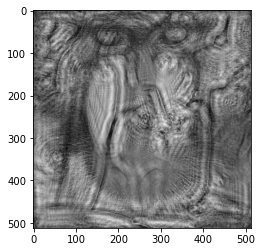

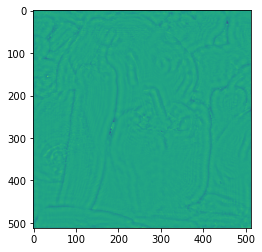

In [25]:
solver = AsSolver(shape=h.shape, dx=1.12, dy=1.12, wavelength=532e-3)

amp = np.abs(solver.reconstruct(h, z))
phase = unwrap_phase(np.angle(solver.reconstruct(h, z)))

plt.imshow(amp, cmap='gray')
plt.show()
plt.imshow(phase, cmap='viridis')
plt.show()

### Multi-Height-Phase-Recovery (MHPR)
Iterative phase retrieval procedure for inline holograms using a sequence of axially displaced hologram images.
#### Import images
- Specify paths to background image (if exists) and hologram sequence and assign their heights in the <b><i>z_values</i></b> array.

In [19]:
bg_path = "PATH_TO_BACKGROUND_IMAGE.tif"

img_seq_paths = [
	"Images/Sequence/0_300.tif",
	"Images/Sequence/1_350.tif",
	"Images/Sequence/2_400.tif",
	"Images/Sequence/3_450.tif",
	"Images/Sequence/4_500.tif",
	"Images/Sequence/5_550.tif",
	"Images/Sequence/6_600.tif",
	"Images/Sequence/7_650.tif"
]

p1 = ImageToArray(bit_depth=16, channel='gray', crop_window=None, dtype='float32')
p2 = ConvertToTensor(dtype=dtype_c)
#bg = import_image(bg_path, preprocessor=[p1, p2])
bg = np.ones((512, 512))  # if no background
p3 = PreprocessHologram(background=bg)
h_seq = import_image_seq(img_seq_paths, preprocessor=[p1, p2, p3])

z_values = [300, 350, 400, 450, 500, 550, 600, 650]
iterations = 100

Image imported from: Images/Sequence/0_300.tif
Image imported from: Images/Sequence/1_350.tif
Image imported from: Images/Sequence/2_400.tif
Image imported from: Images/Sequence/3_450.tif
Image imported from: Images/Sequence/4_500.tif
Image imported from: Images/Sequence/5_550.tif
Image imported from: Images/Sequence/6_600.tif
Image imported from: Images/Sequence/7_650.tif


##### Solve
- Initialize angular spectrum solver.
- Initialize MHPR and pass the solver as parameter. 
- Call mhpr.resolve() and pass hologram sequence, z_values and number of iterations to the as input parameters.

step: 0
step: 5
step: 10
step: 15
step: 20
step: 25
step: 30
step: 35
step: 40
step: 45
step: 50
step: 55
step: 60
step: 65
step: 70
step: 75
step: 80
step: 85
step: 90
step: 95


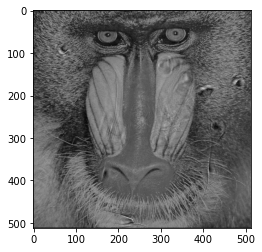

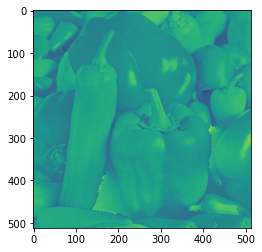

In [20]:
solver = AsSolver(shape=h_seq[0].shape, dx=1.12, dy=1.12, wavelength=532e-3, dtype_f=dtype_f, dtype_c=dtype_c)

with tf.device(device):
    mhpr = MHPR(solver)
    recovered_h = mhpr.resolve(h_seq, z_values, iterations)
    amp = np.abs(recovered_h)
    phase = unwrap_phase(np.angle(recovered_h))
    phase += np.pi
    phase /= 2 * np.pi
    
    plt.imshow(amp, cmap='gray')
    plt.show()
    plt.imshow(phase, cmap='viridis')
    plt.show()

#### Export Results

In [27]:
cmap = matplotlib.cm.get_cmap('viridis')

export_image(amp, os.path.join('Images/Exports', 'amplitude.png'), dtype='uint8')
export_image(phase, os.path.join('Images/Exports', 'phase.png'), dtype='uint8')
export_image(cmap(phase), os.path.join('Images/Exports', 'phase_colored.png'), dtype='uint8')


Image exported to: Images/Exports\amplitude.png
Image exported to: Images/Exports\phase.png
Image exported to: Images/Exports\phase_colored.png
